## Урок 7

### Классификация с помощью kNN. Кластеризация K-means

####  1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от номера соседа.

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

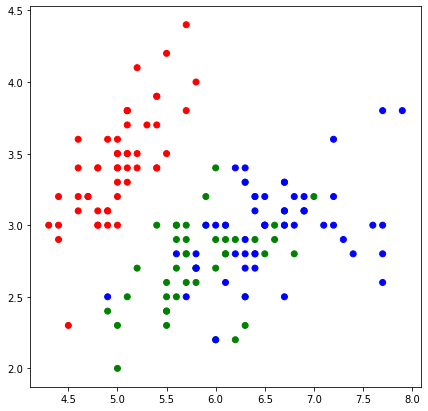

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [3]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
      
    return np.sqrt(distance)

def accuracy(pred, y):
    return (sum(pred == y) / len(y))

def get_graph(X_train, y_train, k, function_knn):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = function_knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [4]:
def knn_weight(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
#         classes = {class_item: 0 for class_item in set(y_train)}
        
        weight_dict = {class_weight: 0 for class_weight in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for num, see_class in enumerate(sorted(test_distances)[0:k]):
            weight = 1 / (num + 1)
            weight_dict[see_class[1]] += weight
            
#             classes[see_class[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
#         answers.append(sorted(classes, key=classes.get)[-1])
        answers.append(sorted(weight_dict, key=weight_dict.get)[-1])
    return answers

In [5]:
k = 15

y_pred = knn_weight(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 15: 0.767


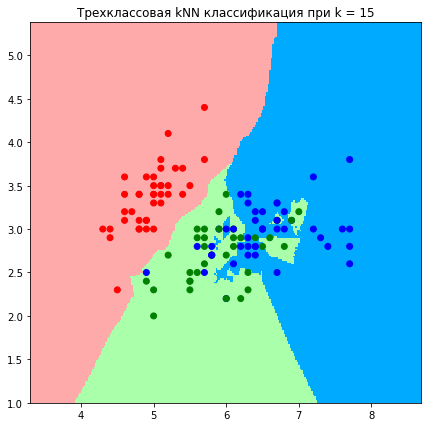

In [6]:
get_graph(X_train, y_train, k, knn_weight)

####  2. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от расстояния до соседа. Сравнить метрики качества и сложность разделяющей гиперплоскости. Сделать выводы.

In [7]:
def knn_weight_distance(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        weight_dict_distance = {class_weight: 0 for class_weight in set(y_train)}
        
        for see_class in sorted(test_distances)[0:k]:
            weight_distance = 1 / (see_class[0] + 1e-5)
            weight_dict_distance[see_class[1]] += weight_distance

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(weight_dict_distance, key=weight_dict_distance.get)[-1])    
    return answers

In [8]:
k = 15

y_pred2 = knn_weight_distance(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred2, y_test):.3f}')

Точность алгоритма при k = 15: 0.833


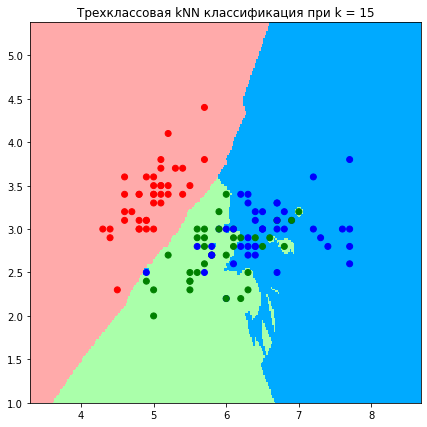

In [9]:
get_graph(X_train, y_train, k, knn_weight_distance)

Добавление весов для соседей в зависимости от расстояния до соседа позволяет быстрее увеличить качество классификации по сравнению с добавлением весов для соседей в зависимости от номера соседа, а также при одном и том же значении k-соседей гиперплоскость в случае установки весов для соседей в зависимости от номера соседа получается более сложной.

####  3. Настроить оптимальное значение числа соседей для моделей из п.1 и п.2, сделать выводы. 

In [81]:
import pandas as pd
def knn_optimal(x_train, y_train, x_test, k):
    df = pd.DataFrame()
    
    base_accuracy = 0
    stop = 0
    
    for k in range(1, k+1, 1):
        y_pred1 = knn_weight(x_train, y_train, x_test, k)
        df[k] = y_pred1
        y_pred2 = knn_weight_distance(X_train, y_train, X_test, k)
        df[f'{k}_2'] = y_pred2 

        df['result'] = [df.iloc[iterr].value_counts().index[0] for iterr in range(len(df))]
        listt = df.result.values.tolist()
        
        acc = accuracy(listt, y_test)
        
        if acc > base_accuracy:
            base_accuracy = acc
            stop = 0
        if acc <= base_accuracy:
            stop += 1
            
        # Если 7 последних значений accuracy показывают отсутствие улучшения или показывают ухудшение, то останавливаемся  
        if stop > 6:
            print(f"Остановка алгоритма при k={k}, accuracy={acc}")
            break
        
    return listt

In [82]:
k = 30
y_pred3 = knn_optimal(X_train, y_train, X_test, k)

print(f'Точность алгоритма при заданном k = {k}: {accuracy(y_pred3, y_test):.3f}')

Остановка алгоритма при k=16, accuracy=0.7666666666666667
Точность алгоритма при заданном k = 30: 0.767


С увеличением количества соседей более 15 метрика accuracy не растет или незначительно приростает. Учет слишком большого количества соседей не приводит к улучшению результатов и не имеет большой практической пользы. Оптимальное значение(k) соседей не превышает 15-ти.